In [16]:
from PIL import Image

im = Image.open("../data/cat.png")
imgwidth, imgheight = im.size
height = imgheight // 3
width = imgwidth // 3
boxs = list()
new_boxs_for_bb_tools = list()

for i in range(0, imgheight, height):
    for j in range(0, imgwidth, width):
        boxs.append((j, i, j + width, i + height))
        new_boxs_for_bb_tools.append((j, j + width, i, i + height))
        
boxs

[(0, 0, 400, 200),
 (400, 0, 800, 200),
 (800, 0, 1200, 200),
 (0, 200, 400, 400),
 (400, 200, 800, 400),
 (800, 200, 1200, 400),
 (0, 400, 400, 600),
 (400, 400, 800, 600),
 (800, 400, 1200, 600)]

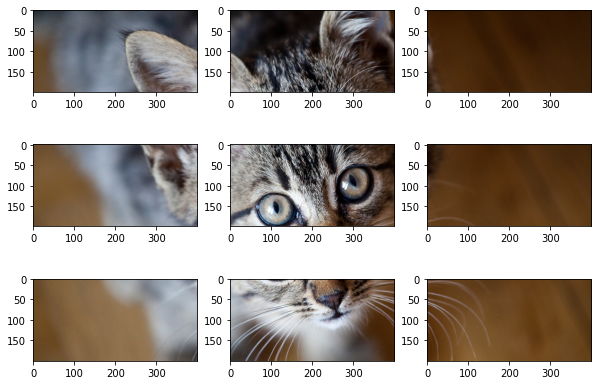

In [17]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))

for i, box in enumerate(boxs, start=1):
    fig.add_subplot(3, 3, i)
    a = im.crop(box)
    imshow(a)

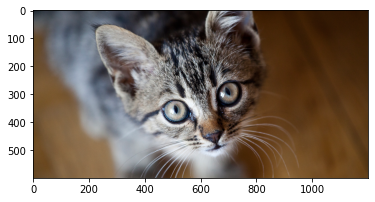

In [18]:
# ahora vamos a ver lo que sería un total bounding box, es decir, toda la imagen para ver
# si podemos confirmar que un bounding box está dentro de otro
total_bb = (0, 0, 1200, 600)
b = im.crop(total_bb)
imshow(b)

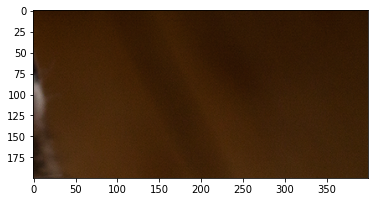

In [19]:
# pip install photutils --> It is a library that has the bounding boxs
from photutils.aperture import BoundingBox

bbox = BoundingBox(ixmin=0, ixmax=1200, iymin=0, iymax=600)
bbox_intersection = bbox.intersection(BoundingBox(*new_boxs_for_bb_tools[2]))
imshow(im.crop((
    bbox_intersection.ixmin,
    bbox_intersection.iymin,
    bbox_intersection.ixmax,
    bbox_intersection.iymax
)))

In [20]:
# ahora probamos una interesección que sabemos que no existe
bbox_intersection = bbox.intersection(BoundingBox(
    ixmin=1201, ixmax=1400, iymin=601, iymax=800
))
if not bbox_intersection:
    print("La bounding box no existe.")

La bounding box no existe.


A continuación, se va a intentar generar una función capaz de separar el espacio y detectar si hay una bounding box.

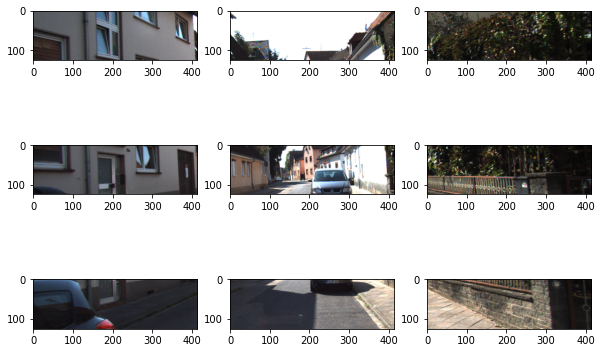

In [21]:
from PIL import Image

def divide_on_6_bbox(image_path):
    im = Image.open(image_path)
    imgwidth, imgheight = im.size
    height = imgheight // 3
    width = imgwidth // 3
    boxs_for_intersection = list()
    boxs_for_printing = list()

    for i in range(0, imgheight, height):
        for j in range(0, imgwidth, width):
            boxs_for_intersection.append((j, j + width, i, i + height))
            boxs_for_printing.append((j, i, j + width, i + height))
            
    return im, boxs_for_printing, boxs_for_intersection

im, boxs, box_int = divide_on_6_bbox("../data/000003.png")

fig = plt.figure(figsize=(10, 7))

for i, box in enumerate(boxs, start=1):
    fig.add_subplot(3, 3, i)
    a = im.crop(box)
    imshow(a)

In [22]:
def get_labels(label_filename):
    """
        get_labels pozwala zwrocic. bounding boxy dla kazdego samochodu. Dzięki niemu możemy zobaczyć kontory samochodow,
        zwraca liste z wartooscciami bounding box.
        
        :param label_filename: filname like kitti_3d/{training,testing}/label_2/id.txt
        Returns Pandas DataFrame
        
        The label files contain the following information, which can be read and
        written using the matlab tools (readLabels.m, writeLabels.m) provided within
        this devkit. All values (numerical or strings) are separated via spaces,
        each row corresponds to one object. The 15 columns represent:
        #Values    Name      Description
        ----------------------------------------------------------------------------
           1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                             'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                             'Misc' or 'DontCare'
           1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                             truncated refers to the object leaving image boundaries
           1    occluded     Integer (0,1,2,3) indicating occlusion state:
                             0 = fully visible, 1 = partly occluded
                             2 = largely occluded, 3 = unknown
           1    alpha        Observation angle of object, ranging [-pi..pi]
           4    bbox         2D bounding box of object in the image (0-based index):
                             contains left, top, right, bottom pixel coordinates
           3    dimensions   3D object dimensions: height, width, length (in meters)
           3    location     3D object location x,y,z in camera coordinates (in meters)
           1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
           1    score        Only for results: Float, indicating confidence in
                             detection, needed for p/r curves, higher is better.
    """
    data =  pd.read_csv(os.path.join(LABEL_PATH,label_filename), sep=" ", 
                       names=['label', 'truncated', 'occluded', 'alpha', 
                              'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 
                              'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 
                              'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'])
    # parametros para bbox ixmin=0, ixmax=1200, iymin=0, iymax=600
    bboxs = [r for r in 
             data[["bbox_xmin", "bbox_xmax", "bbox_ymin", "bbox_ymax"]].itertuples(
                index=False
             )]
    
    return data, bboxs

[Pandas(bbox_xmin=599.41, bbox_xmax=629.75, bbox_ymin=156.4, bbox_ymax=189.25), Pandas(bbox_xmin=387.63, bbox_xmax=423.81, bbox_ymin=181.54, bbox_ymax=203.12), Pandas(bbox_xmin=676.6, bbox_xmax=688.98, bbox_ymin=163.95, bbox_ymax=193.93), Pandas(bbox_xmin=503.89, bbox_xmax=590.61, bbox_ymin=169.71, bbox_ymax=190.13), Pandas(bbox_xmin=511.35, bbox_xmax=527.81, bbox_ymin=174.96, bbox_ymax=187.45), Pandas(bbox_xmin=532.37, bbox_xmax=542.68, bbox_ymin=176.35, bbox_ymax=185.27), Pandas(bbox_xmin=559.62, bbox_xmax=575.4, bbox_ymin=175.83, bbox_ymax=183.15)]
(375, 1242, 3)


<Figure size 720x504 with 0 Axes>

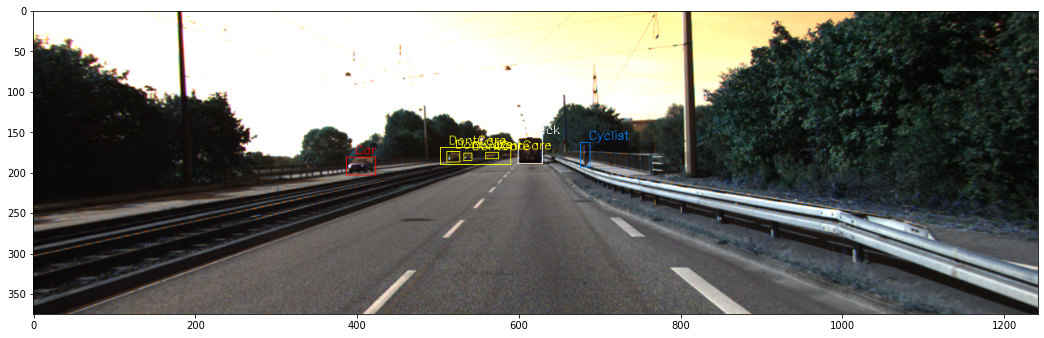

In [26]:
import cv2
import os
import pandas as pd

fig = plt.figure(figsize=(10, 7))

IMAGE_PATH = "../data/"
LABEL_PATH = "../data/"

def open_image(image_filename):
    return cv2.imread(os.path.join(IMAGE_PATH, image_filename))
    
    
def draw_box2d_id(id):
    """
        pozwala zobazyc jakie BoundingBox sa dla naszego zestawu danych
    """
    return draw_box2d(open_image(id + '.png'),
                      *get_labels(id + '.txt'))

LABEL_COLORS = {
    'Car': (255,0,0), 
    'Van': (255,255,0), 
    'Truck': (255,255,255),
    'Pedestrian': (0,255,255),
    'Person_sitting': (0,255,255), 
    'Cyclist': (0,128,255), 
    'Tram': (128,0,0),
    'Misc': (0,255,255),
    'DontCare': (255,255,0)
}

def draw_box2d(image, labels, bboxs, ax = None):
    """
        pozwala rysowac boxy 2d dla naszego modelu.
        
        
        :param label_filename: filname like kitti_3d/{training,testing}/label_2/id.txt
        Returns Pandas DataFrame
    """
    print(bboxs)
    
    img = image.copy()
    print(img.shape)
    for index, row in labels.iterrows():
        left_corner = (int(row.bbox_xmin), int(row.bbox_ymin))
        right_corner = (int(row.bbox_xmax), int(row.bbox_ymax))
        label_color = LABEL_COLORS.get(row.label,(0,255,0))
        
        img = cv2.rectangle(img, 
                            left_corner, right_corner, label_color, 1)
        img = cv2.putText(img, str(row.label), 
                          (left_corner[0] + 10, left_corner[1] - 4) , 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                          label_color, 1)
    if ax == None:
        plt.imshow(img)
    else:
        ax.imshow(img)

fig = plt.figure(figsize=(18, 20))
draw_box2d_id('000001')

Found intersection in 4 for bbox BoundingBox(ixmin=5, ixmax=214, iymin=229, iymax=250)
Found intersection in 5 for bbox BoundingBox(ixmin=614, ixmax=727, iymin=181, iymax=250)
Found intersection in 5 for bbox BoundingBox(ixmin=522, ixmax=547, iymin=202, iymax=219)
Found intersection in 7 for bbox BoundingBox(ixmin=5, ixmax=214, iymin=250, iymax=367)
Found intersection in 8 for bbox BoundingBox(ixmin=614, ixmax=727, iymin=250, iymax=284)


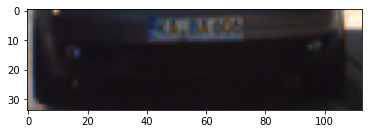

In [24]:
from photutils.aperture import BoundingBox

def detect_where_are_the_boxes(bboxs, im, bboxs_intersection):
    for i, bbox_intersection in enumerate(bboxs_intersection, start=1):
        #print(bbox_intersection)
        base_bbox = BoundingBox(*bbox_intersection)
        for bbox in bboxs:
            #print(*map(int,bbox))
            bbox_intersection = base_bbox.intersection(BoundingBox(*map(int, bbox)))
            if bbox_intersection:
                print(f"Found intersection in {i} for bbox {bbox_intersection}")
                imshow(im.crop((
                    bbox_intersection.ixmin,
                    bbox_intersection.iymin,
                    bbox_intersection.ixmax,
                    bbox_intersection.iymax
                )))
                continue

            
_, bboxs = get_labels("./000003.txt")
detect_where_are_the_boxes(bboxs, im, box_int)